In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Load and preprocess data
df_train = pd.read_csv('../input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')

df_test = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv')

spots_train = df_train['meantemp'].to_numpy().reshape(-1, 1)
spots_test = df_test['meantemp'].to_numpy().reshape(-1, 1)

scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.transform(spots_test).flatten().tolist()

In [4]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [5]:
x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [7]:
# Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [8]:
# Training function
def train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs, method):
    train_losses = []
    val_losses = []
    early_stop_count = 0
    min_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        epoch_train_losses = []
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        train_loss = np.mean(epoch_train_losses)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_epoch_losses = []
        with torch.no_grad():
            for batch in test_loader:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_epoch_losses.append(loss.item())

        val_loss = np.mean(val_epoch_losses)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= 5:
            print(f"{method}: Early stopping!")
            break
        print(f"{method} - Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [9]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predictions.extend(outputs.squeeze().tolist())

    rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
    return rmse, predictions

# FINE TUNINING PROCESSES

# Learning Rate Scheduling (LR Scheduling)

Learning rate scheduling is a technique used to adjust the learning rate during training. In our implementation, we use the ReduceLROnPlateau scheduler.
Here's how it works:

We start with an initial learning rate (0.001 in our case).
The scheduler monitors the validation loss after each epoch.
If the validation loss doesn't improve for a certain number of epochs (patience=3 in our code), the scheduler reduces the learning rate by a factor (0.5 in our code).
This process continues throughout training.

The benefit of this method is that it allows the model to start with a larger learning rate for faster initial progress, then automatically reduce the learning rate when the model stops improving, allowing for finer adjustments and potentially better convergence.

In [10]:
# Fine-tuning methods
def lr_scheduling(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
    return optimizer, scheduler

# Gradual Unfreezing

Gradual unfreezing is a technique often used in transfer learning, but it can also be effective in fine-tuning. Here's how we've implemented it:

Initially, we freeze all layers of the model except the last layer (the decoder in our case).
We train the model for some time with only the last layer being updated.
In a full implementation, we would then gradually unfreeze earlier layers over time.

The idea behind this method is to allow the model to adapt its final layer to the specific task first, then gradually allow earlier layers to be fine-tuned. This can help prevent catastrophic forgetting in transfer learning scenarios and can lead to more stable training.
Note: In our current implementation, we've only implemented the initial freezing step. To fully implement gradual unfreezing, you would need to add logic to unfreeze layers over time during training.

In [11]:
def gradual_unfreezing(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
    
    # Freeze all layers except the last one
    for param in model.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True
    
    return optimizer, scheduler

# Discriminative Fine-Tuning

Discriminative fine-tuning applies different learning rates to different parts of the model. The intuition is that later layers (closer to the output) might need to be updated more than earlier layers. Here's how we've implemented it:

We group the parameters of the model into two groups: those in the decoder and those in the encoder.
We assign a higher learning rate (0.001) to the decoder parameters.
We assign a lower learning rate (0.0001) to the encoder parameters.

This method allows for more nuanced updates to the model. The idea is that the earlier layers of the model (the encoder in our case) have learned more general features that might not need as much adjustment, while the later layers (the decoder) might need more significant updates to adapt to the specific task.

In [12]:
def discriminative_finetuning(model):
    params = list(model.named_parameters())
    optimizer_grouped_parameters = [
        {"params": [p for n, p in params if "decoder" in n], "lr": 0.001},
        {"params": [p for n, p in params if "encoder" in n], "lr": 0.0001},
    ]
    optimizer = torch.optim.Adam(optimizer_grouped_parameters)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)
    return optimizer, scheduler

In [13]:
# Train and evaluate models
criterion = nn.MSELoss()
epochs = 1000

methods = [
    ("LR Scheduling", lr_scheduling),
    ("Gradual Unfreezing", gradual_unfreezing),
    ("Discriminative Fine-Tuning", discriminative_finetuning)
]

results = {}

for method_name, method_func in methods:
    model = TransformerModel().to(device)
    optimizer, scheduler = method_func(model)
    train_losses, val_losses = train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs, method_name)
    rmse, predictions = evaluate_model(model, test_loader)
    results[method_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "rmse": rmse,
        "predictions": predictions
    }
    print(f"{method_name} - RMSE: {rmse:.4f}")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


LR Scheduling - Epoch 1/1000, Train Loss: 0.2122, Validation Loss: 0.0842
LR Scheduling - Epoch 2/1000, Train Loss: 0.0846, Validation Loss: 0.0615
LR Scheduling - Epoch 3/1000, Train Loss: 0.0786, Validation Loss: 0.0555
LR Scheduling - Epoch 4/1000, Train Loss: 0.0746, Validation Loss: 0.0474
LR Scheduling - Epoch 5/1000, Train Loss: 0.0734, Validation Loss: 0.0571
LR Scheduling - Epoch 6/1000, Train Loss: 0.0752, Validation Loss: 0.0654
LR Scheduling - Epoch 7/1000, Train Loss: 0.0753, Validation Loss: 0.0446
LR Scheduling - Epoch 8/1000, Train Loss: 0.0708, Validation Loss: 0.0584
LR Scheduling - Epoch 9/1000, Train Loss: 0.0681, Validation Loss: 0.0932
LR Scheduling - Epoch 10/1000, Train Loss: 0.0694, Validation Loss: 0.0579
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.
LR Scheduling - Epoch 11/1000, Train Loss: 0.0694, Validation Loss: 0.0684
LR Scheduling - Epoch 12/1000, Train Loss: 0.0672, Validation Loss: 0.0438
LR Scheduling - Epoch 13/1000, Train Loss: 0.06

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Gradual Unfreezing - Epoch 1/1000, Train Loss: 0.5022, Validation Loss: 0.1109
Gradual Unfreezing - Epoch 2/1000, Train Loss: 0.1694, Validation Loss: 0.0787
Gradual Unfreezing - Epoch 3/1000, Train Loss: 0.1408, Validation Loss: 0.0743
Gradual Unfreezing - Epoch 4/1000, Train Loss: 0.1472, Validation Loss: 0.0701
Gradual Unfreezing - Epoch 5/1000, Train Loss: 0.1284, Validation Loss: 0.0677
Gradual Unfreezing - Epoch 6/1000, Train Loss: 0.1254, Validation Loss: 0.0648
Gradual Unfreezing - Epoch 7/1000, Train Loss: 0.1158, Validation Loss: 0.0663
Gradual Unfreezing - Epoch 8/1000, Train Loss: 0.1068, Validation Loss: 0.0654
Gradual Unfreezing - Epoch 9/1000, Train Loss: 0.1045, Validation Loss: 0.0621
Gradual Unfreezing - Epoch 10/1000, Train Loss: 0.1030, Validation Loss: 0.0646
Gradual Unfreezing - Epoch 11/1000, Train Loss: 0.0957, Validation Loss: 0.0600
Gradual Unfreezing - Epoch 12/1000, Train Loss: 0.1004, Validation Loss: 0.0598
Gradual Unfreezing - Epoch 13/1000, Train Loss: 0

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Discriminative Fine-Tuning - Epoch 1/1000, Train Loss: 0.1771, Validation Loss: 0.0755
Discriminative Fine-Tuning - Epoch 2/1000, Train Loss: 0.0869, Validation Loss: 0.0569
Discriminative Fine-Tuning - Epoch 3/1000, Train Loss: 0.0776, Validation Loss: 0.0530
Discriminative Fine-Tuning - Epoch 4/1000, Train Loss: 0.0778, Validation Loss: 0.0544
Discriminative Fine-Tuning - Epoch 5/1000, Train Loss: 0.0666, Validation Loss: 0.0706
Discriminative Fine-Tuning - Epoch 6/1000, Train Loss: 0.0704, Validation Loss: 0.0497
Discriminative Fine-Tuning - Epoch 7/1000, Train Loss: 0.0677, Validation Loss: 0.0503
Discriminative Fine-Tuning - Epoch 8/1000, Train Loss: 0.0677, Validation Loss: 0.0463
Discriminative Fine-Tuning - Epoch 9/1000, Train Loss: 0.0694, Validation Loss: 0.0443
Discriminative Fine-Tuning - Epoch 10/1000, Train Loss: 0.0702, Validation Loss: 0.0444
Discriminative Fine-Tuning - Epoch 11/1000, Train Loss: 0.0657, Validation Loss: 0.0456
Discriminative Fine-Tuning - Epoch 12/100

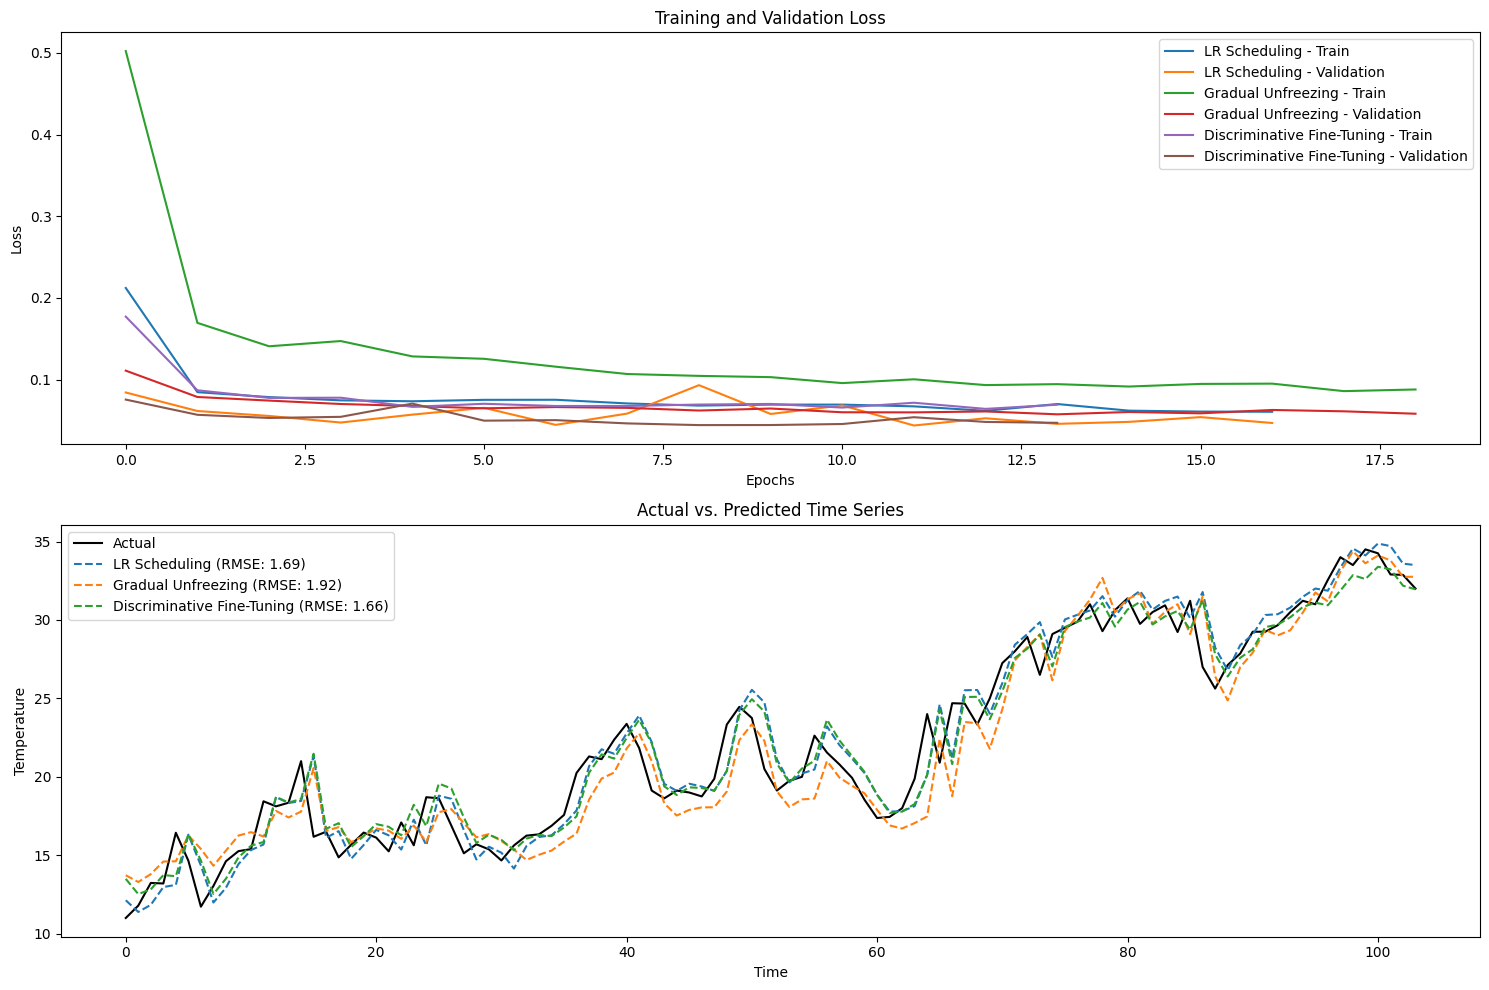

In [14]:
# Plotting
plt.figure(figsize=(15, 10))

# Training and Validation Loss
plt.subplot(2, 1, 1)
for method_name, method_results in results.items():
    plt.plot(method_results["train_losses"], label=f"{method_name} - Train")
    plt.plot(method_results["val_losses"], label=f"{method_name} - Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Actual vs Predicted
plt.subplot(2, 1, 2)
actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
plt.plot(actual, label='Actual', color='black')
for method_name, method_results in results.items():
    predicted = scaler.inverse_transform(np.array(method_results["predictions"]).reshape(-1, 1))
    plt.plot(predicted, label=f'{method_name} (RMSE: {method_results["rmse"]:.2f})', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Time Series')
plt.legend()

plt.tight_layout()
plt.show()

# Hybrid Fine-tuning 

In [15]:
# Hybrid fine-tuning method
def hybrid_finetuning(model, epochs):
    # Phase 1: Start with only the decoder unfrozen
    for param in model.parameters():
        param.requires_grad = False
    for param in model.decoder.parameters():
        param.requires_grad = True
    
    params = list(model.named_parameters())
    optimizer_grouped_parameters = [
        {"params": [p for n, p in params if "decoder" in n], "lr": 0.001},
        {"params": [p for n, p in params if "encoder" in n], "lr": 0.0001},
    ]
    optimizer = torch.optim.Adam(optimizer_grouped_parameters)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

    # Phase 2: Gradually unfreeze layers
    unfreeze_epochs = [epochs // 3, 2 * epochs // 3]  # Unfreeze at 1/3 and 2/3 of total epochs
    
    def update_unfreezing(epoch):
        if epoch == unfreeze_epochs[0]:
            print("Unfreezing transformer_encoder")
            for param in model.transformer_encoder.parameters():
                param.requires_grad = True
        elif epoch == unfreeze_epochs[1]:
            print("Unfreezing encoder and pos_encoder")
            for param in model.encoder.parameters():
                param.requires_grad = True
            for param in model.pos_encoder.parameters():
                param.requires_grad = True

    return optimizer, scheduler, update_unfreezing

In [16]:
# Modified training function to accommodate hybrid approach
def train_model_hybrid(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs, method, update_unfreezing=None):
    train_losses = []
    val_losses = []
    early_stop_count = 0
    min_val_loss = float('inf')

    for epoch in range(epochs):
        if update_unfreezing:
            update_unfreezing(epoch)

        model.train()
        epoch_train_losses = []
        for batch in train_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())

        train_loss = np.mean(epoch_train_losses)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_epoch_losses = []
        with torch.no_grad():
            for batch in test_loader:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_epoch_losses.append(loss.item())

        val_loss = np.mean(val_epoch_losses)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= 5:
            print(f"{method}: Early stopping!")
            break
        print(f"{method} - Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

In [17]:
# Train and evaluate models
criterion = nn.MSELoss()
epochs = 1000

methods = [
    ("LR Scheduling", lr_scheduling),
    ("Gradual Unfreezing", gradual_unfreezing),
    ("Discriminative Fine-Tuning", discriminative_finetuning),
    ("Hybrid", hybrid_finetuning)
]

results = {}

for method_name, method_func in methods:
    model = TransformerModel().to(device)
    if method_name == "Hybrid":
        optimizer, scheduler, update_unfreezing = method_func(model, epochs)
        train_losses, val_losses = train_model_hybrid(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs, method_name, update_unfreezing)
    else:
        optimizer, scheduler = method_func(model)
        train_losses, val_losses = train_model(model, train_loader, test_loader, optimizer, scheduler, criterion, epochs, method_name)
    
    rmse, predictions = evaluate_model(model, test_loader)
    results[method_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "rmse": rmse,
        "predictions": predictions
    }
    print(f"{method_name} - RMSE: {rmse:.4f}")

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


LR Scheduling - Epoch 1/1000, Train Loss: 0.3611, Validation Loss: 0.0709
LR Scheduling - Epoch 2/1000, Train Loss: 0.0808, Validation Loss: 0.0717
LR Scheduling - Epoch 3/1000, Train Loss: 0.0721, Validation Loss: 0.0584
LR Scheduling - Epoch 4/1000, Train Loss: 0.0783, Validation Loss: 0.0917
LR Scheduling - Epoch 5/1000, Train Loss: 0.0730, Validation Loss: 0.0551
LR Scheduling - Epoch 6/1000, Train Loss: 0.0664, Validation Loss: 0.0499
LR Scheduling - Epoch 7/1000, Train Loss: 0.0692, Validation Loss: 0.0686
LR Scheduling - Epoch 8/1000, Train Loss: 0.0694, Validation Loss: 0.0535
LR Scheduling - Epoch 9/1000, Train Loss: 0.0685, Validation Loss: 0.0668
Epoch 00010: reducing learning rate of group 0 to 5.0000e-04.
LR Scheduling - Epoch 10/1000, Train Loss: 0.0676, Validation Loss: 0.0672
LR Scheduling: Early stopping!
LR Scheduling - RMSE: 2.1104


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Gradual Unfreezing - Epoch 1/1000, Train Loss: 0.5044, Validation Loss: 0.2406
Gradual Unfreezing - Epoch 2/1000, Train Loss: 0.1694, Validation Loss: 0.1317
Gradual Unfreezing - Epoch 3/1000, Train Loss: 0.1365, Validation Loss: 0.1224
Gradual Unfreezing - Epoch 4/1000, Train Loss: 0.1320, Validation Loss: 0.1267
Gradual Unfreezing - Epoch 5/1000, Train Loss: 0.1231, Validation Loss: 0.1042
Gradual Unfreezing - Epoch 6/1000, Train Loss: 0.1062, Validation Loss: 0.1019
Gradual Unfreezing - Epoch 7/1000, Train Loss: 0.1003, Validation Loss: 0.0980
Gradual Unfreezing - Epoch 8/1000, Train Loss: 0.0964, Validation Loss: 0.0993
Gradual Unfreezing - Epoch 9/1000, Train Loss: 0.0929, Validation Loss: 0.0833
Gradual Unfreezing - Epoch 10/1000, Train Loss: 0.0923, Validation Loss: 0.0807
Gradual Unfreezing - Epoch 11/1000, Train Loss: 0.0859, Validation Loss: 0.0799
Gradual Unfreezing - Epoch 12/1000, Train Loss: 0.0834, Validation Loss: 0.0750
Gradual Unfreezing - Epoch 13/1000, Train Loss: 0

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Discriminative Fine-Tuning - Epoch 1/1000, Train Loss: 0.2155, Validation Loss: 0.0716
Discriminative Fine-Tuning - Epoch 2/1000, Train Loss: 0.0850, Validation Loss: 0.0526
Discriminative Fine-Tuning - Epoch 3/1000, Train Loss: 0.0821, Validation Loss: 0.0505
Discriminative Fine-Tuning - Epoch 4/1000, Train Loss: 0.0743, Validation Loss: 0.0528
Discriminative Fine-Tuning - Epoch 5/1000, Train Loss: 0.0743, Validation Loss: 0.0515
Discriminative Fine-Tuning - Epoch 6/1000, Train Loss: 0.0759, Validation Loss: 0.0542
Epoch 00007: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00007: reducing learning rate of group 1 to 5.0000e-05.
Discriminative Fine-Tuning - Epoch 7/1000, Train Loss: 0.0747, Validation Loss: 0.0543
Discriminative Fine-Tuning - Epoch 8/1000, Train Loss: 0.0738, Validation Loss: 0.0494
Discriminative Fine-Tuning - Epoch 9/1000, Train Loss: 0.0655, Validation Loss: 0.0567
Discriminative Fine-Tuning - Epoch 10/1000, Train Loss: 0.0706, Validation Loss: 0.0506
Discr

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Hybrid - Epoch 1/1000, Train Loss: 0.9023, Validation Loss: 0.2873
Hybrid - Epoch 2/1000, Train Loss: 0.2264, Validation Loss: 0.1082
Hybrid - Epoch 3/1000, Train Loss: 0.1616, Validation Loss: 0.0969
Hybrid - Epoch 4/1000, Train Loss: 0.1598, Validation Loss: 0.0870
Hybrid - Epoch 5/1000, Train Loss: 0.1400, Validation Loss: 0.0815
Hybrid - Epoch 6/1000, Train Loss: 0.1278, Validation Loss: 0.0754
Hybrid - Epoch 7/1000, Train Loss: 0.1324, Validation Loss: 0.0700
Hybrid - Epoch 8/1000, Train Loss: 0.1102, Validation Loss: 0.0711
Hybrid - Epoch 9/1000, Train Loss: 0.1070, Validation Loss: 0.0685
Hybrid - Epoch 10/1000, Train Loss: 0.1043, Validation Loss: 0.0664
Hybrid - Epoch 11/1000, Train Loss: 0.0984, Validation Loss: 0.0675
Hybrid - Epoch 12/1000, Train Loss: 0.0997, Validation Loss: 0.0676
Hybrid - Epoch 13/1000, Train Loss: 0.0920, Validation Loss: 0.0658
Hybrid - Epoch 14/1000, Train Loss: 0.0892, Validation Loss: 0.0677
Hybrid - Epoch 15/1000, Train Loss: 0.0899, Validation Lo

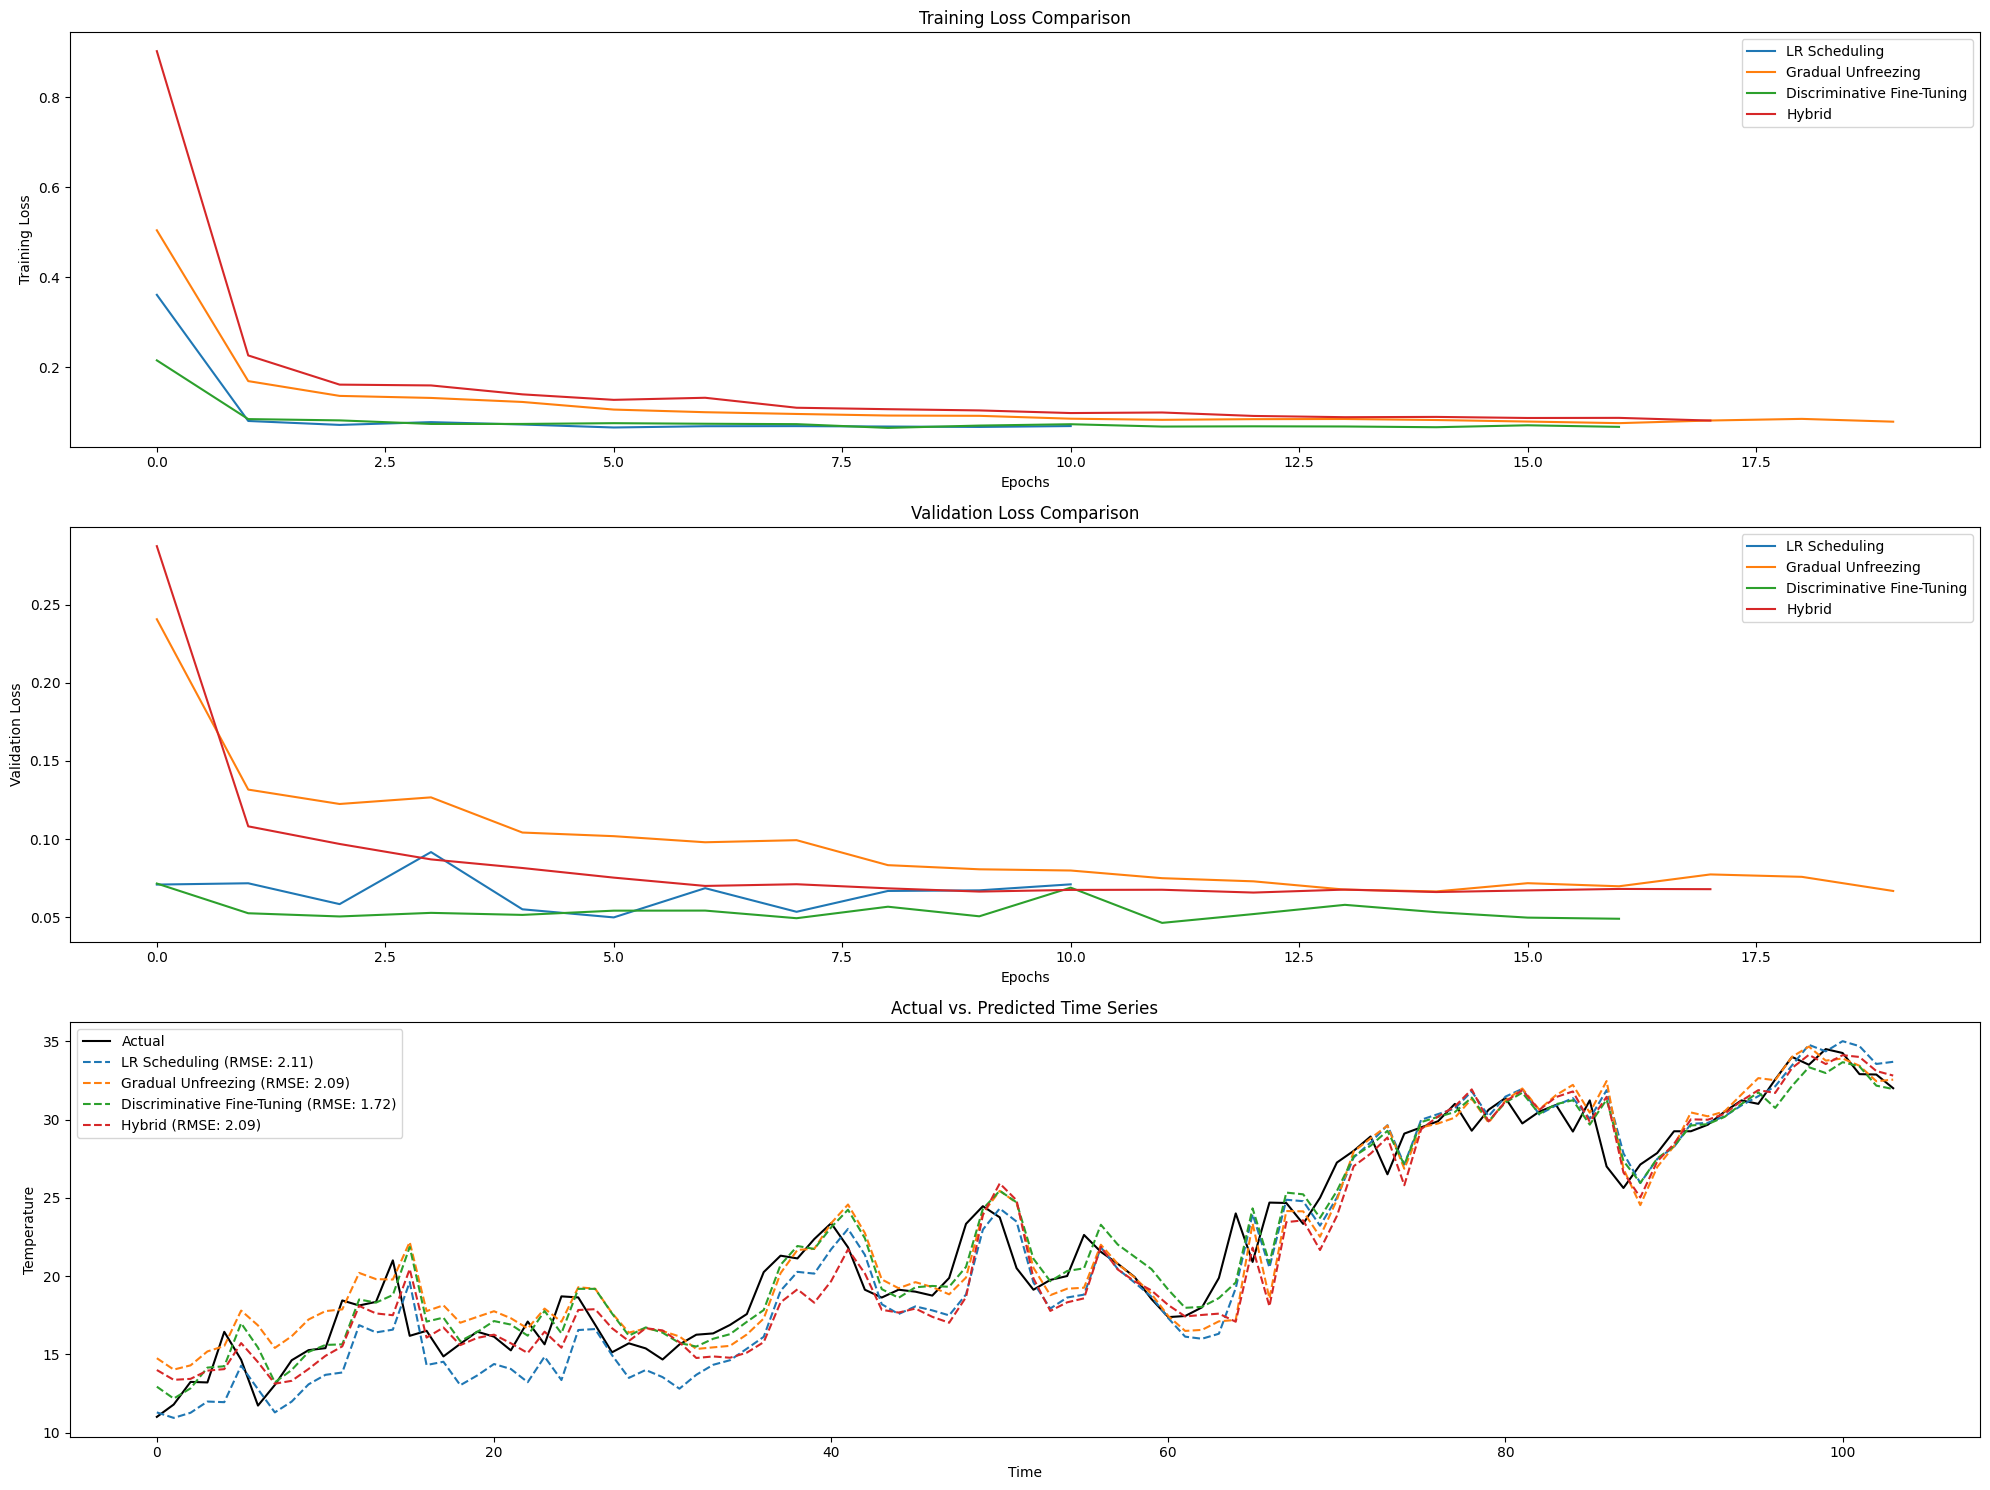

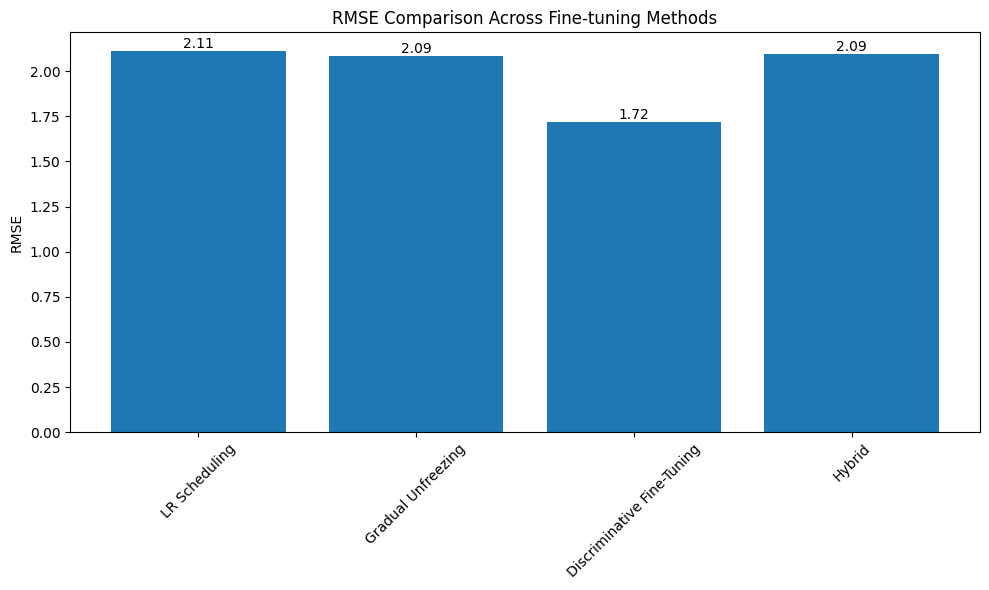

In [18]:
# Plotting
plt.figure(figsize=(20, 15))

# Training Loss
plt.subplot(3, 1, 1)
for method_name, method_results in results.items():
    plt.plot(method_results["train_losses"], label=f"{method_name}")
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()

# Validation Loss
plt.subplot(3, 1, 2)
for method_name, method_results in results.items():
    plt.plot(method_results["val_losses"], label=f"{method_name}")
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()

# Actual vs Predicted
plt.subplot(3, 1, 3)
actual = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))
plt.plot(actual, label='Actual', color='black')
for method_name, method_results in results.items():
    predicted = scaler.inverse_transform(np.array(method_results["predictions"]).reshape(-1, 1))
    plt.plot(predicted, label=f'{method_name} (RMSE: {method_results["rmse"]:.2f})', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Actual vs. Predicted Time Series')
plt.legend()

plt.tight_layout()
plt.show()

# Bar plot for RMSE comparison
# Bar plot for RMSE comparison
plt.figure(figsize=(10, 6))
rmse_values = [results[method[0]]["rmse"] for method in methods]
plt.bar([method[0] for method in methods], rmse_values)
plt.ylabel('RMSE')
plt.title('RMSE Comparison Across Fine-tuning Methods')
plt.xticks(rotation=45)
for i, v in enumerate(rmse_values):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Benchmarks for error calculation and Comparison

> Symmetrical Mean Absolute Percentage Error (sMAPE)

$$
e_{sM} = \frac{200\%}{k} \sum_{t=1}^{k} \frac{|y_t - \hat{y}_t|}{|y_t + \hat{y}_t|}
$$

> Mean Absolute Scaled Error (MASE)

$$
e_{MA} = \frac{1}{k} \sum_{t=1}^{k} \frac{|y_t - \hat{y}_t|}{\frac{1}{n-m} \sum_{i=m+1}^{n} |y_i - y_{i-m}|}
$$

> Mean Wrong-Estimation Shares ($\rho_U$ and $\rho_O$)

$$
\rho_U = \frac{1}{k} \sum_{t=1}^{k} \max(\text{sgn}(y_t - \hat{y}_t), 0)
$$

$$
\rho_O = \frac{1}{k} \sum_{t=1}^{k} \max(\text{sgn}(\hat{y}_t - y_t), 0)
$$

> Mean Wrong-Accuracy Shares ($\delta_U$ and $\delta_O$)

$$
\delta_U = \begin{cases} 
\frac{1}{k \cdot \rho_U} \sum_{t=1}^{k} \frac{\max(y_t - \hat{y}_t, 0)}{|y_t|}, & \text{if } \rho_U > 0 \\
0, & \text{otherwise}
\end{cases}
$$

$$
\delta_O = \begin{cases} 
\frac{1}{k \cdot \rho_O} \sum_{t=1}^{k} \frac{\max(\hat{y}_t - y_t, 0)}{|y_t|}, & \text{if } \rho_O > 0 \\
0, & \text{otherwise}
\end{cases}
$$

> The Mean Squared Error (MSE) 

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

> Coefficient of Determination (R²)

$$
\text{R^2} = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
$$


In [67]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
def smape(y_pred, y_actual):
    """
    Symmetrical Mean Absolute Percentage Error (sMAPE)
    """
    ans = (200.0 / len(y_pred)) * np.sum(np.abs(y_actual - y_pred) / (np.abs(y_actual + y_pred)))
    print(f"sMAPE: {ans:.2f}%")
    return ans

def mase(actual, forecast, m=1):
    actual,forecast = forecast,actual
    """
    Calculate the Mean Absolute Scaled Error (MASE).

    Parameters:
    - actual: array-like, actual values
    - forecast: array-like, forecasted values
    - m: int, seasonality (default is 1 for non-seasonal data)

    Returns:
    - MASE: float, Mean Absolute Scaled Error
    """
    #actual = np.asarray(actual)
    #forecast = np.asarray(forecast)

    # Calculate MAE of the forecasting model
    mae_model = np.mean(np.abs(actual - forecast))

    # Calculate MAE of the naive forecast (m steps ahead)
    naive_forecast_errors = np.abs(actual[m:] - actual[:-m])
    mae_naive = np.mean(naive_forecast_errors)

    # Calculate MASE
    mase_ = mae_model / mae_naive
    print(f"mase: {mase_:.2f}")
    return mase_

def rho_u(y_pred, y_actual):
    """
    Mean Wrong-Estimation Shares (ρU)
    """
    ans = np.mean(np.maximum(np.sign(y_actual - y_pred), 0))
    print(f"ρU: {ans:.2f}")
    return ans

def rho_o(y_pred, y_actual):
    """
    Mean Wrong-Estimation Shares (ρO)
    """
    ans = np.mean(np.maximum(np.sign(y_pred - y_actual), 0))
    print(f"ρO: {ans:.2f}")
    return ans

def delta_u(y_pred, y_actual):
    """
    Mean Wrong-Accuracy Shares (δU)
    """
    rho_u_val = rho_u(y_pred, y_actual)
    if rho_u_val > 0:
        ans = np.mean(np.maximum(y_actual - y_pred, 0) / np.abs(y_actual)) / rho_u_val
    else:
        ans = 0
    print(f"δU: {ans:.2f}")
    return ans

def delta_o(y_pred, y_actual):
    """
    Mean Wrong-Accuracy Shares (δO)
    """
    rho_o_val = rho_o(y_pred, y_actual)
    if rho_o_val > 0:
        ans = np.mean(np.maximum(y_pred - y_actual, 0) / np.abs(y_actual)) / rho_o_val
    else:
        ans = 0
    print(f"δO: {ans:.2f}")
    return ans

def mean_squared_error_(y_pred, y_actual):
    """
    Mean Squared Error (MSE)
    """
    ans = np.mean((y_pred-y_actual)*(y_pred-y_actual))
    print(f"MSE: {ans:.2f}")
    return ans

def r_squared(y_pred, y_actual):
    """
    Coefficient of Determination (R²)
    """
    r2 = r2_score(y_actual, y_pred)
    print(f"R²: {r2:.2f}")
    return r2


In [56]:
!pip install pyfiglet
import pyfiglet

figlet = pyfiglet.Figlet(font='slant')




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.3 MB/s eta 0:00:0000:01


In [68]:
y_true = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

for method_name, method_results in results.items():
    y_pred = scaler.inverse_transform(np.array(method_results["predictions"]).reshape(-1, 1))
    print("="*100)
    print("="*100)
    large_text = figlet.renderText(method_name)
    print(large_text)
    print("="*100)
    mape_=mean_absolute_percentage_error(y_true, y_pred)
    print("Mean Absolute Percentage Error", mape_)
    print("="*100)
    mse_= mean_squared_error_(y_true, y_pred)
    print("Mean Squared Error",mse_)
    print("="*100)
    print("RMSE", (mse_)**0.5)
    print("Root Mean Squared Error", (mse_)**0.5)
    print("="*100)
    smape_ = smape(y_pred,y_true)
    print("Symmetrical Mean Absolute Percentage Error (sMAPE)", smape_)
    print("="*100)
    mase_ = mase(y_pred,y_true)
    print("Mean Absolute Scaled Error (MASE)" , mase_)
    print("="*100)
    rho_u_ = rho_u(y_pred,y_true)
    print("Mean Wrong-Estimation Shares (ρU)", rho_u_)
    print("="*100)
    rho_o_ = rho_o(y_pred,y_true)
    print("Mean Wrong-Estimation Shares (ρO)", rho_o_)
    print("="*100)
    delta_u_ = delta_u(y_pred,y_true)
    print("Mean Wrong-Estimation Shares (δU)", delta_u_)
    print("="*100)
    delta_o_ = delta_o(y_pred,y_true)
    print("Mean Wrong-Estimation Shares (δO)", delta_o_)
    print("="*100)
    r_squared_ = r_squared(y_pred,y_true)
    print("Cofficient of Determination (R²)", r_squared_)
    print("="*100)
   

    __    ____     _____      __             __      ___            
   / /   / __ \   / ___/_____/ /_  ___  ____/ /_  __/ (_)___  ____ _
  / /   / /_/ /   \__ \/ ___/ __ \/ _ \/ __  / / / / / / __ \/ __ `/
 / /___/ _, _/   ___/ / /__/ / / /  __/ /_/ / /_/ / / / / / / /_/ / 
/_____/_/ |_|   /____/\___/_/ /_/\___/\__,_/\__,_/_/_/_/ /_/\__, /  
                                                           /____/   

Mean Absolute Percentage Error 0.08365285696578997
MSE: 4.45
Mean Squared Error 4.453733438804088
RMSE 2.110387035309895
Root Mean Squared Error 2.110387035309895
sMAPE: 8.82%
Symmetrical Mean Absolute Percentage Error (sMAPE) 8.815148185720473
mase: 1.29
Mean Absolute Scaled Error (MASE) 1.2949832671894708
ρU: 0.71
Mean Wrong-Estimation Shares (ρU) 0.7115384615384616
ρO: 0.29
Mean Wrong-Estimation Shares (ρO) 0.28846153846153844
ρU: 0.71
δU: 0.09
Mean Wrong-Estimation Shares (δU) 0.09315632597760777
ρO: 0.29
δO: 0.06
Mean Wrong-Estimation Shares (δO) 0.060210966736639386
R²: 0.

# Transformer Model for Time Series Forecasting: A Deep Dive into Fine-Tuning Techniques

## Introduction

Time series forecasting is a critical task in many fields, from finance to climate science. With the advent of deep learning, we've seen significant improvements in forecasting accuracy. In this blog post, we'll explore how to use a Transformer model for time series forecasting and dive deep into various fine-tuning techniques to enhance its performance.

## The Transformer Model

Transformers, originally introduced for natural language processing tasks, have shown remarkable performance in various domains, including time series forecasting. Our model is a simplified version of the original Transformer, adapted for univariate time series data.

### Model Architecture

Our Transformer model consists of the following components:

1. **Input Encoding**: A linear layer that projects the input data into a higher-dimensional space.
2. **Positional Encoding**: Adds information about the sequence order to the input.
3. **Transformer Encoder**: The core of the model, consisting of self-attention mechanisms and feed-forward networks.
4. **Output Decoding**: A final linear layer that projects the encoder output to our target dimension.

Here's a brief overview of each component:

#### Input Encoding
The input encoding layer transforms our 1-dimensional time series data into a higher-dimensional representation. This allows the model to capture more complex patterns in the data.

#### Positional Encoding
Since Transformers process input in parallel, they need explicit information about the order of the sequence. The positional encoding adds this information using sine and cosine functions of different frequencies.

#### Transformer Encoder
The Transformer Encoder is composed of multiple layers, each containing:
- A multi-head self-attention mechanism, which allows the model to attend to different parts of the input sequence.
- A feed-forward network that processes the attention output.

#### Output Decoding
The final layer transforms the high-dimensional output of the Transformer Encoder back to our target dimension (in this case, a single value for univariate forecasting).

## Data Preparation

For time series forecasting, we prepare our data as follows:

1. We use a sliding window approach to create input sequences and corresponding target values.
2. Each input sequence is of length `SEQUENCE_SIZE` (10 in our case), and the target is the next value in the series.
3. We normalize the data using StandardScaler to ensure all values are on a similar scale.

## Fine-Tuning Techniques

To improve the performance of our Transformer model, we've implemented several fine-tuning techniques. Let's explore each of them in detail:

### 1. Learning Rate Scheduling

Learning rate scheduling is a technique to adjust the learning rate during training. We use the `ReduceLROnPlateau` scheduler, which reduces the learning rate when the model's performance plateaus.

**How it works:**
- We start with an initial learning rate (0.001 in our case).
- After each epoch, we evaluate the model's performance on the validation set.
- If the performance doesn't improve for a certain number of epochs (patience=3), we reduce the learning rate by a factor of 0.5.
- This process continues throughout training.

**Benefits:**
- Allows for larger initial learning rates for faster initial progress.
- Automatically reduces the learning rate as the model converges, allowing for finer adjustments.
- Can help the model overcome local minima and find better global minima.

### 2. Gradual Unfreezing

Gradual unfreezing is a technique often used in transfer learning, but it can also be effective in fine-tuning from scratch.

**How it works:**
- We start by freezing all layers of the model except the last layer (the decoder in our case).
- We train the model for some time with only the last layer being updated.
- Gradually, we unfreeze earlier layers over time.

**Benefits:**
- Allows the model to adapt its final layer to the specific task first.
- Gradually allows earlier layers to be fine-tuned, which can lead to more stable training.
- Can help prevent catastrophic forgetting in transfer learning scenarios.

### 3. Discriminative Fine-Tuning

Discriminative fine-tuning applies different learning rates to different parts of the model.

**How it works:**
- We group the parameters of the model into two groups: those in the decoder and those in the encoder.
- We assign a higher learning rate (0.001) to the decoder parameters.
- We assign a lower learning rate (0.0001) to the encoder parameters.

**Benefits:**
- Allows for more nuanced updates to the model.
- Based on the intuition that later layers (closer to the output) might need to be updated more than earlier layers.
- Can lead to better performance, especially when different parts of the model have different optimal learning rates.

### 4. Hybrid Approach

Our hybrid approach combines all three techniques mentioned above.

**How it works:**
- We start with discriminative fine-tuning, setting different learning rates for the encoder and decoder.
- We implement gradual unfreezing, starting with only the decoder unfrozen and gradually unfreezing other layers.
- Throughout training, we use learning rate scheduling with ReduceLROnPlateau.

**Benefits:**
- Combines the advantages of all three methods.
- Potentially leads to better performance by leveraging multiple optimization strategies.
- Allows for a more flexible and adaptive training process.

## Evaluation and Comparison

To evaluate and compare these fine-tuning techniques, we:

1. Train the model using each technique separately and the hybrid approach.
2. Monitor training and validation loss throughout the training process.
3. Calculate the Root Mean Square Error (RMSE) on a test set for each method.
4. Create visualizations to compare:
   - Training loss curves
   - Validation loss curves
   - Actual vs. predicted values
   - RMSE scores across all methods

These comparisons allow us to understand:
- How quickly each method converges
- The final performance of each method
- Whether the hybrid approach offers improvements over individual methods

## Conclusion

Fine-tuning techniques can significantly impact the performance of Transformer models in time series forecasting. By implementing learning rate scheduling, gradual unfreezing, discriminative fine-tuning, and a hybrid approach, we can potentially improve our model's accuracy and training stability.

The effectiveness of each method can vary depending on the specific dataset and task. Therefore, it's crucial to experiment with different techniques and combinations to find the optimal approach for your particular time series forecasting problem.

Remember, the world of deep learning is constantly evolving. While these techniques have shown promise, always stay open to new methods and innovations in the field of time series forecasting and model optimization.